In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Class_vogn import train_model_cc_fast,csvDataset,ToTensor
import torch.nn.functional as F
from active_function import *
from sklearn.model_selection import train_test_split
from vogn import VOGN

class EvalNet(nn.Module):

    def __init__(self, in_size=9, hidden=64, dropout_rate=None):
        super(EvalNet, self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.f1 = nn.Linear(in_size, hidden)
        self.f2 = nn.Linear(hidden,  hidden)
        self.f3 = nn.Linear(hidden,  1)

    def forward(self, x):
        out = x
        out = F.relu(self.f1(out))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.f2(out))
        if self.dropout:
            out = self.dropout(out)
        out = self.f3(out)
        return out  
    
class BaseNet(nn.Module):
    def __init__(self,dropout_rate=None):
        super(type(self), self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = nn.Linear(9, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        if self.dropout:
            out = self.dropout(out)
        x = F.relu(self.layer2(x))
        if self.dropout:
            out = self.dropout(out)
        out = self.layer3(x)
        return out

In [5]:
uncertainty = ['mc_dropout','bootstrap','vogn']

In [8]:
'a'+'c' + uncertainty[0] +'_'

'acmc_dropout_'

In [2]:
Xtrain = np.load('opAmp_280nm_GF55_Mod_30P_lbl/trainx.npy')
Ytrain = np.load('opAmp_280nm_GF55_Mod_30P_lbl/trainy.npy')*1.
Xtest = np.load('opAmp_280nm_GF55_Mod_30P_lbl/testx.npy')
Ytest = np.load('opAmp_280nm_GF55_Mod_30P_lbl/testy.npy')*1.


for i in range(9):
    Xtrain[:,i]=(Xtrain[:,i] - Xtrain[:,i].mean())/(Xtrain[:,i].std())
    Xtest[:,i]=(Xtest[:,i] - Xtest[:,i].mean())/(Xtest[:,i].std())
Ytrain = Ytrain.reshape(-1,1)
Ytest = Ytest.reshape(-1,1) 

In [6]:
torch.cuda.set_device(1)

In [8]:
correct = np.zeros(100)
for x in range(2):
    a = np.random.choice(3420,20+20*x,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=1000,prior_prec=30, prec_init=30, num_samples=4)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])


49
49


In [17]:
for n, p in model.named_parameters():
    print (p,n)
    if(p.requires_grad) and ("bias" not in n):
            print(n)
            print(p.grad)

Parameter containing:
tensor([[ 2.9161e-02,  1.0130e-02, -9.2288e-03, -1.9997e-03, -6.5995e-02,
          4.9942e-03,  8.5276e-03, -1.0572e-03,  4.9246e-03],
        [-2.7820e-01, -6.6908e-02,  2.6424e-01, -2.6140e-01, -6.3598e-01,
         -2.4332e-01, -1.9838e-01, -4.1837e-01,  5.2506e-01],
        [-7.5120e-02, -1.0402e-01,  8.9916e-02, -1.3215e-02, -8.0750e-02,
          7.2648e-02, -7.1175e-02,  3.2943e-02,  5.7159e-02],
        [ 2.0885e-02,  1.7369e-02,  6.4046e-02, -4.7534e-02,  3.0895e-03,
          3.9550e-02,  2.1787e-02,  4.9360e-02,  6.7319e-04],
        [-3.9992e-02, -8.2005e-03,  3.4172e-02, -4.6968e-02, -1.1008e-01,
         -7.6947e-02, -3.1951e-02, -7.6014e-02,  9.4013e-02],
        [-2.1785e-01, -3.4577e-01,  1.7160e-01,  7.1034e-02,  1.2708e-02,
          1.8729e-01, -2.2380e-01,  6.7063e-02,  8.4501e-02],
        [-4.9249e-02, -3.5608e-02,  5.7390e-02, -2.0645e-02, -4.1320e-02,
          3.6806e-04, -2.5020e-02, -1.4292e-02,  3.1576e-02],
        [ 1.8588e-01,  1.3

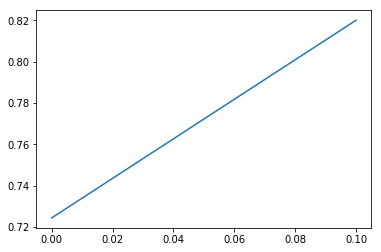

In [9]:
plt.plot(np.arange(2)/10,correct[:2])

In [ ]:
for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())

In [7]:
correct = np.zeros(100)
for x in range(10):
    a = np.random.choice(3420,50,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=50,prior_prec=30, prec_init=30, num_samples=4,lr=0.00001+x*0.0005)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])

49
49
49
49
49
49
49
49
49
49


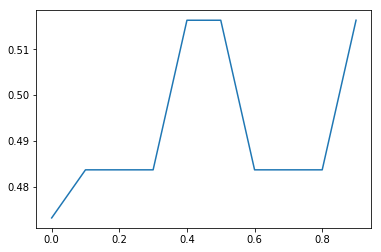

In [8]:
plt.plot(np.arange(10)/10,correct[:10])

In [9]:
correct = np.zeros(100)
for x in range(10):
    a = np.random.choice(3420,50,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=50+x*100,prior_prec=30, prec_init=30, num_samples=4)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])

49
49
49
49
49
49
49
49
49
49


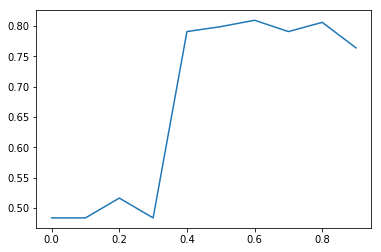

In [10]:
plt.plot(np.arange(10)/10,correct[:10])

_________________

____________

In [13]:
df = pd.ExcelFile('Test Case 1 - OpAmp_280nm_GF55.xlsx').parse()

In [14]:
b = []
for i in list(df.columns):
    b.append(i)

In [17]:
train = ['VDD','Ib','Lg1','Lg2','Lrf','Wcf','Wg1','Wg2','temperature']
target = ['ACM_G','SR','CMRR','NOISE','PSRR','PhaseMargin_PM','BandWidth']

In [21]:
X = df[train].values
Y = df[target].values
X.shape,Y.shape

((6912, 9), (6912, 7))

In [32]:
for i in range(9):
    X[:,i]=(X[:,i] - X[:,i].mean())/(X[:,i].std())
for i in range(7):
    Y[:,i]=(Y[:,i] - Y[:,i].mean())/(Y[:,i].std())

In [33]:
trainX_tmp, testX, trainY_tmp, testY  = train_test_split(X, Y, test_size=0.2, random_state=1)
trainX_tmp, valX, trainY_tmp, valY = train_test_split(trainX_tmp, trainY_tmp, test_size=0.25, random_state=1)

In [34]:
trainX_tmp.shape,valX.shape,testX.shape,4146+2*1383

((4146, 9), (1383, 9), (1383, 9), 6912)

In [41]:
a = np.random.rand(101,5,2000)
a.shape

(101, 5, 2000)

In [52]:
def random(x):
    a,b,c = x.shape
    
    return np.mean(np.std(x,axis=0),axis=0)


In [53]:
random(a).shape

(2000,)

In [9]:
a = [9,4,1,8]
b = np.arange(10)

In [13]:
np.setdiff1d(b,a).shape[0]

6